Author: Alanna Anderson

Class: URSP688Y

Semester: Spring 2024

Data sources:


*   DP05 ACS 5-Year Demographic and Housing Estimates from 2010-2015
  (https://data.census.gov/table/ACSDP5Y2010.DP05?q=population%20in%20maryland&g=040XX00US24$0500000&moe=false)


*   United States Census Bureau County Profiles


*   A long-term dataset on wild bee abundance in Mid-Atlantic United States by Melanie Kammerer, John F. Tooker & Christina M. Groziner (https://www.nature.com/articles/s41597-020-00577-0)



In [1]:
#Import Packages
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn
import scipy

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory
os.chdir('/content/drive/MyDrive/URSP688Y-FinalProject')

#Create list with counties and their land area in sq mile
#Source: United States Census Bureau County Profiles
density = {'county': ['Allegany', 'Anne Arundel', 'Baltimore', 'Baltimore city', 'Calvert','Caroline','Carroll','Cecil','Charles','Dorchester','Frederick','Garrett','Harford','Howard','Kent','Montgomery',"Prince George's","Queen Anne's",'Somerset',"St. Mary's",'Talbot','Washington','Wicomico','Worcester'],
        'area': [422.2,414.8,598.4,80.95,213.2,319.4,447.6,346.3,457.8,540.8,660.6,649.1,437.1,251.0,277.0,493.1,482.6,371.7,319.7,358.6,268.6,457.8,374.4,468.4]}

#Create dataframe with counties and their area in sq mile
density = pd.DataFrame(density)

Mounted at /content/drive


In [2]:
#Create function to read through human data csvs and clean them according to parameters set below
def clean_population_from_csv(population_csv):
  pop_df = pd.read_csv(population_csv)

  #Use lamba function to remove unwanted label characters in label (grouping)
  pop_df['Label (Grouping)'] = pop_df.apply(lambda x: x['Label (Grouping)'].strip(), axis=1)

  #Use isin to separate population and housing data from the rest of the data
  pop_df = pop_df.loc[pop_df['Label (Grouping)'].isin(['Total population', 'Total housing units'])]
  pop_df = pop_df.iloc[[0,-1]]

  #Transpose DataFrame
  pop_df = pop_df.set_index('Label (Grouping)').transpose()

  #Use lamba function to remove the table's version of an na value
  pop_df = pop_df.loc[pop_df['Total housing units'].isin(['(X)'])==False]
  pop_df = pop_df.reset_index()
  pop_df = pop_df.drop(index=0)

  #Use lamba function to remove unwanted label characters in county column then merge
  pop_df['county'] = pop_df.apply(lambda x: x['index'].replace('!!Estimate',"").replace(', Maryland', '').replace(' County',''), axis=1)
  pop_df = pd.merge(density, pop_df, on='county', how='inner')

  #Use lamba function to remove unwanted label characters in county and total housing units columns
  pop_df['county'] = pop_df.apply(lambda x: x['county'].replace('Baltimore city','Baltimore City'),axis=1)
  pop_df['Total housing units'] = pop_df.apply(lambda x: x['Total housing units'].replace(',',''),axis=1)

  #Change character type of total housing units to float
  pop_df['Total housing units']=pop_df['Total housing units'].astype(float)

  #Use lamba function to remove unwanted label characters in total population column
  pop_df['Total population'] = pop_df.apply(lambda x: x['Total population'].replace(',',''),axis=1)

  #Change character type of total population to float
  pop_df['Total population']=pop_df['Total population'].astype(float)

  #Create density column by dividing values in total population by area
  pop_df['density'] = pop_df['Total population'] / pop_df['area']
  return pop_df[['county','density', 'area', 'Total population','Total housing units']]

#Create function to create separate csvs with values from the years 2010-15
def clean_population_data():
  population_df = pd.DataFrame()
  for year in ['2010','2011','2012','2013','2014','2015']:
    new_year_df = clean_population_from_csv('pop'+year+'.csv')
    new_year_df['year'] = pd.Series([year] * len(new_year_df))
    population_df = pd.concat([population_df, new_year_df])
  return population_df[['year','county','area','Total population', 'density','Total housing units']]

In [3]:
#Create function to read through bee data csvs and clean them according to parameters set below
def clean_bee_population_data():

  #Read csvs with bee data with low memory set to false to handle large amount of data
  bee_all_occur = pd.read_csv('1OccurrenceLevel_AllBees.csv', low_memory=False)
  bee_trap_info = pd.read_csv('3TransectLevel_WithTrapInfo.csv', low_memory=False)

  # Create new dataframe from existing dataframe
  bee_all_occur = bee_all_occur[['SiteID','state','county']].copy()
  bee_trap_info = bee_trap_info[['SiteID_Year','AbundDayTrap']].copy()

  #Use the _ character to split/separate values in the siteid year column
  bee_trap_info[['SiteID','Year']] = bee_trap_info['SiteID_Year'].str.split('_',expand=True)
  bee_trap_info = bee_trap_info[['SiteID', 'Year', 'AbundDayTrap']]
  bee_trap_info = bee_trap_info[bee_trap_info['Year'].isin(['2010','2011','2012','2013','2014','2015'])]
  county_bee_df = pd.DataFrame(columns=['Year','County','AbundDayTrap','N'])

  #For loop iterates through trap locations, adding abundance to appropriate county and year column
  for i,row in bee_trap_info.iterrows():
    i = bee_all_occur[bee_all_occur['SiteID']==row['SiteID']].index[0]
    county = bee_all_occur.iloc[i]['county']
    if ((county_bee_df['Year']==row['Year']) & (county_bee_df['County']==county)).any():
      i = ((county_bee_df['Year']==row['Year']) & (county_bee_df['County']==county)).argmax()
      county_bee_df.at[i,'AbundDayTrap']+=row['AbundDayTrap']
      county_bee_df.at[i,'N']+=1
    else:
      new_row = {'Year':[row['Year']],'County':[county],'AbundDayTrap':[row['AbundDayTrap']],'N':[1]}
      county_bee_df = pd.concat([county_bee_df,pd.DataFrame(new_row)],ignore_index=True)

  #Remove county values that are na or not in Maryland
  county_bee_df=county_bee_df[county_bee_df['County'].isin([np.nan,'District of Columbia','Sussex'])==False]

  #Create AvgAbundDayTrap column by dividing values in AbundDayTrap by N
  county_bee_df['AvgAbundDayTrap'] = county_bee_df['AbundDayTrap'] / county_bee_df['N']
  return county_bee_df

In [4]:
#Assign names to dataframes with human and bee data then merge using left join
pop_df = clean_population_data()

#This takes a long time to run (about :40)
bee_df = clean_bee_population_data()
df = pd.merge(bee_df, pop_df, how = 'left', left_on =['Year','County'], right_on=['year','county'])

<Axes: xlabel='AvgAbundDayTrap', ylabel='Total housing units'>

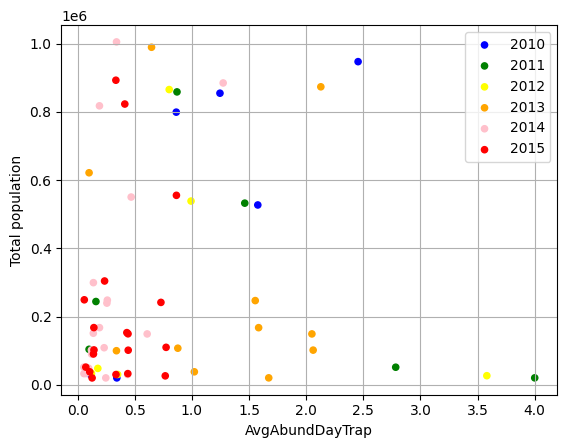

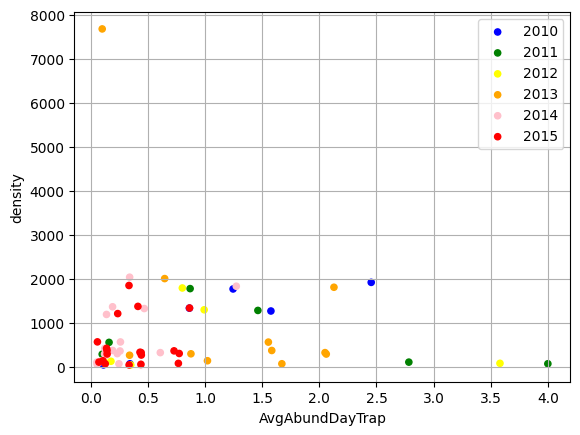

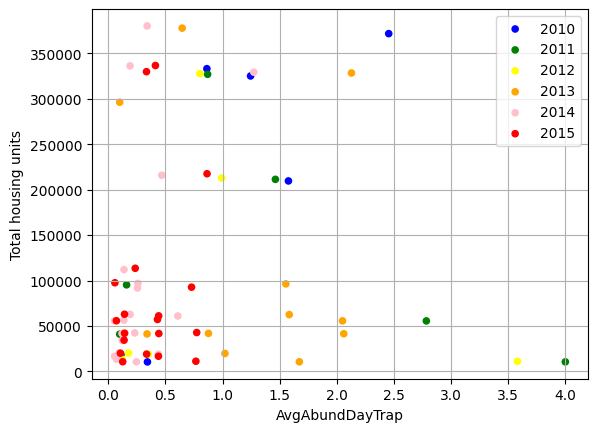

In [5]:
#Write function to color the scatter plot points according to year
def color_by_year(Year):
  if Year=='2010':
    return "blue"
  elif Year=='2011':
    return "green"
  elif Year=='2012':
    return "yellow"
  elif Year=='2013':
    return "orange"
  elif Year=='2014':
    return "pink"
  elif Year=='2015':
    return "red"
df["val"] = df['Year'].apply(color_by_year)

#Create function to produce scatter plot of data colored by year
def scatter_by_year(column):
  axis = df[df['Year']=='2010'].plot.scatter('AvgAbundDayTrap', column,c='val',label='2010')
  df[df['Year']=='2011'].plot.scatter('AvgAbundDayTrap',column,c='val',label='2011',ax=axis)
  df[df['Year']=='2012'].plot.scatter('AvgAbundDayTrap',column,c='val',label='2012',ax=axis)
  df[df['Year']=='2013'].plot.scatter('AvgAbundDayTrap',column,c='val',label='2013',ax=axis)
  df[df['Year']=='2014'].plot.scatter('AvgAbundDayTrap',column,c='val',label='2014',ax=axis)
  df[df['Year']=='2015'].plot.scatter('AvgAbundDayTrap',column,c='val',label='2015',ax=axis)
  axis.grid(True)
  return axis

scatter_by_year('Total population')
scatter_by_year('density')
scatter_by_year('Total housing units')


In [40]:
#Prepare testing and training sets
x_train, x_test, y_train, y_test = train_test_split(df['Total population'],df['AvgAbundDayTrap'],random_state=1)

# Initialize the model object
linreg = LinearRegression()

def shape(series):
  return series.to_numpy().reshape((-1,1))

# Estimate/fit the model
print(shape(x_train).shape)
linreg.fit(shape(x_train), shape(y_train))
y_pred = linreg.predict(shape(x_test))

#Print values
# print(y_pred)
# print(shape(y_test))
# print(y_pred-shape(y_test))
sklearn.metrics.r2_score(shape(y_test),y_pred)



(51, 1)


0.002055108900415714

In [52]:
#Prepare testing and training sets
x_train, x_test, y_train, y_test = train_test_split(df[['Total population','Total housing units','density']],df['AvgAbundDayTrap'],random_state=1)

# Initialize the model object
linreg = LinearRegression()

def shape(series, n):
  return series.to_numpy().reshape((-1,n))

# Estimate/fit the model
linreg.fit(shape(x_train,3), shape(y_train,1))
y_pred = linreg.predict(shape(x_test,3))

#Print values
#print(y_pred)
#print(y_pred-shape(y_test,1))
sklearn.metrics.r2_score(shape(y_test,1),y_pred)


-0.13707308580378874

In [53]:
#Split dataset into two groups by density
low_density_abundance = df[df['density']<250]['AvgAbundDayTrap'].to_numpy(dtype=float)
high_density_abundance = df[df['density']>250]['AvgAbundDayTrap'].to_numpy(dtype=float)

result = scipy.stats.ttest_ind(high_density_abundance, low_density_abundance)
result

In [10]:
#Create final csv with combined population, housing, and bee information organized by year and county
final_export = df[['Year','County','area','Total population','density','Total housing units', 'N', 'AvgAbundDayTrap']].copy()
final_export = final_export.rename(columns={'area': 'Area', 'density': 'Density','N':'Number of Traps', 'AvgAbundDayTrap':'Average Abundance'})
final_export = final_export.sort_values(['Year','County']).reset_index(drop=True)
final_export.to_csv('BeeandHumanDemographic.csv',index=False)
final_export

Additional visualizations for this project are created below

In [12]:
# Create variables containing county information by year
only_2010 = pop_df.where(pop_df['year']=='2010').dropna()
only_2011 = pop_df.where(pop_df['year']=='2011').dropna()
only_2012 = pop_df.where(pop_df['year']=='2012').dropna()
only_2013 = pop_df.where(pop_df['year']=='2013').dropna()
only_2014 = pop_df.where(pop_df['year']=='2014').dropna()
only_2015 = pop_df.where(pop_df['year']=='2015').dropna()

Text(0, 0.5, 'County')

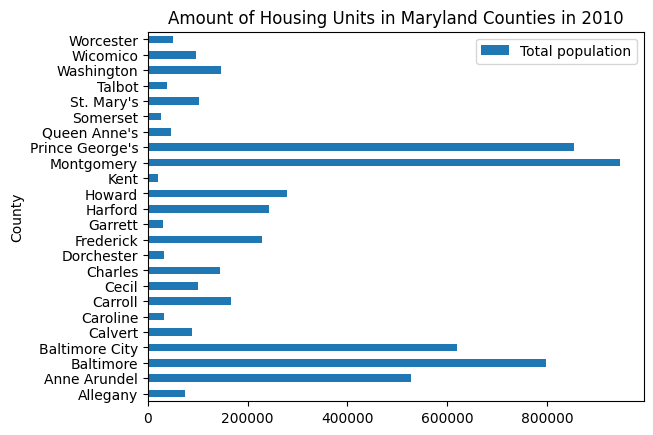

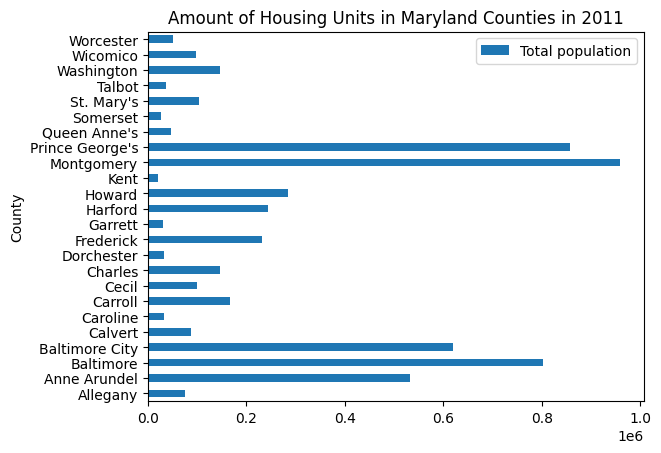

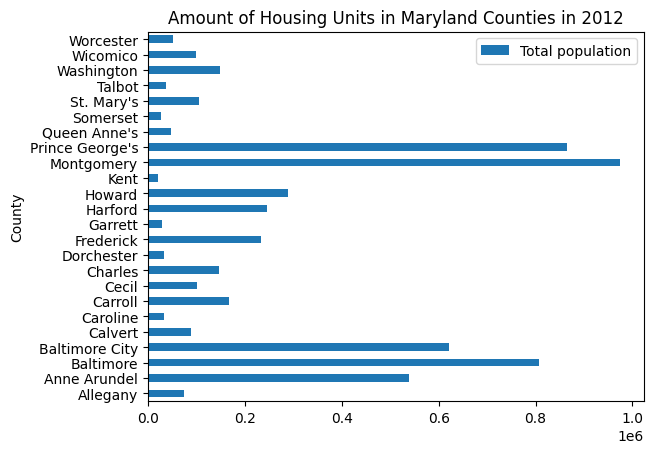

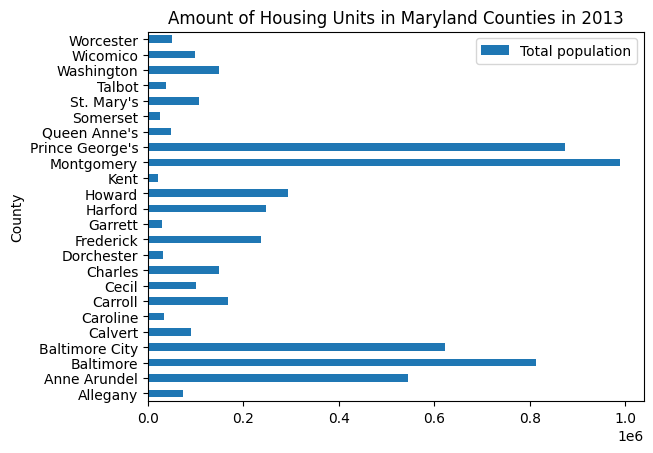

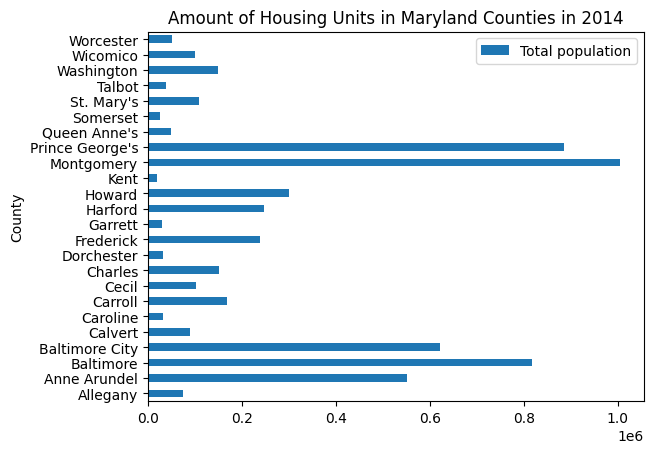

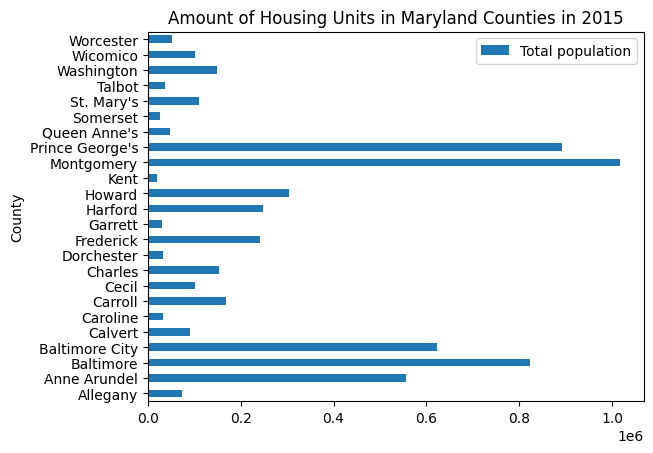

In [13]:
#Plot horizontal bar charts of amount of housing units for each county from 2010-2015

#2010 housing units by county
plot_2010_housing = only_2010.plot.barh(x="county",y="Total population")
plot_2010_housing.set_title('Amount of Housing Units in Maryland Counties in 2010')
plot_2010_housing.set_ylabel('County')

#2011 housing units by county
plot_2011_housing = only_2011.plot.barh(x="county",y="Total population")
plot_2011_housing.set_title('Amount of Housing Units in Maryland Counties in 2011')
plot_2011_housing.set_ylabel('County')

#2012 housing units by county
plot_2012_housing = only_2012.plot.barh(x="county",y="Total population")
plot_2012_housing.set_title('Amount of Housing Units in Maryland Counties in 2012')
plot_2012_housing.set_ylabel('County')

#2013 housing units by county
plot_2013_housing = only_2013.plot.barh(x="county",y="Total population")
plot_2013_housing.set_title('Amount of Housing Units in Maryland Counties in 2013')
plot_2013_housing.set_ylabel('County')

#2014 housing units by county
plot_2014_housing = only_2014.plot.barh(x="county",y="Total population")
plot_2014_housing.set_title('Amount of Housing Units in Maryland Counties in 2014')
plot_2014_housing.set_ylabel('County')

#2015 housing units by county
plot_2015_housing = only_2015.plot.barh(x="county",y="Total population")
plot_2015_housing.set_title('Amount of Housing Units in Maryland Counties in 2015')
plot_2015_housing.set_ylabel('County')

Text(0, 0.5, 'County')

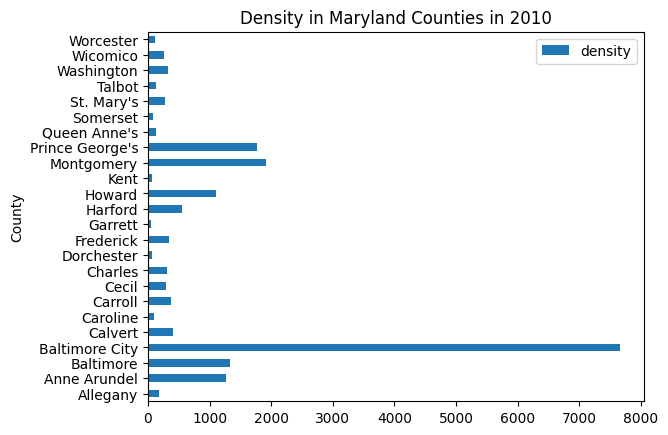

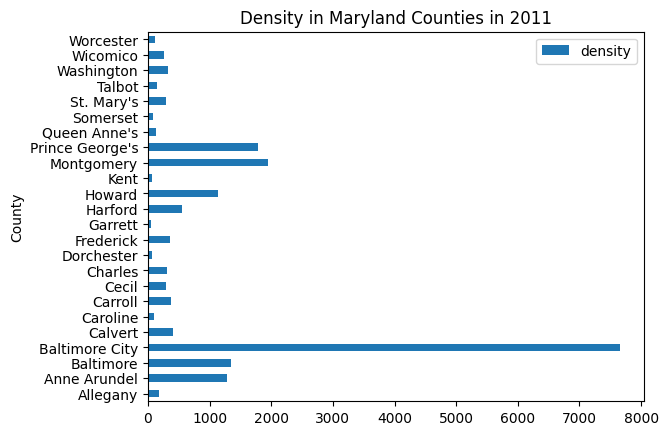

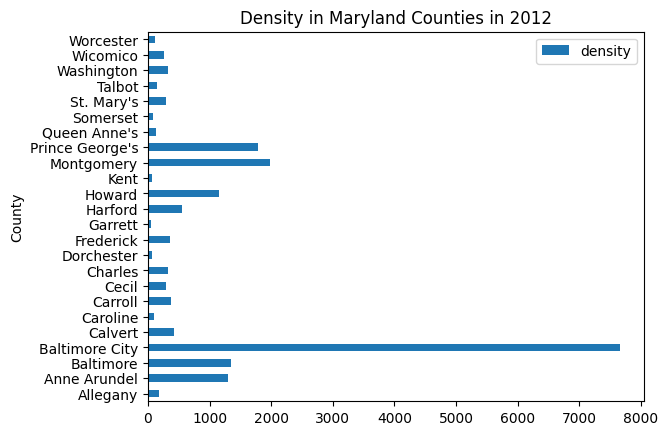

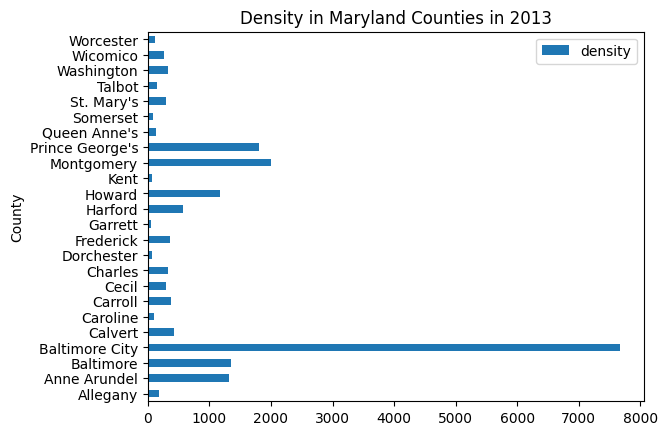

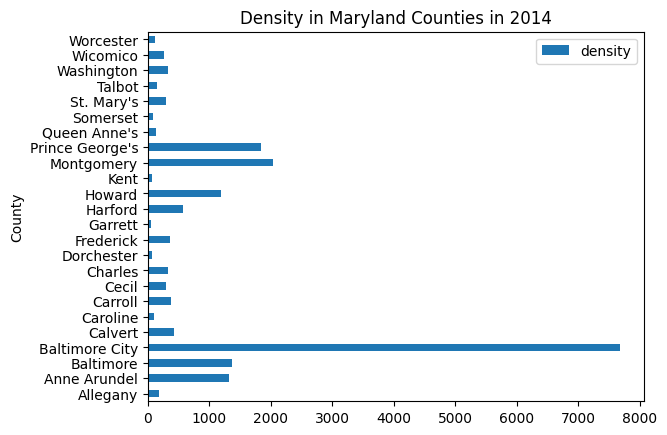

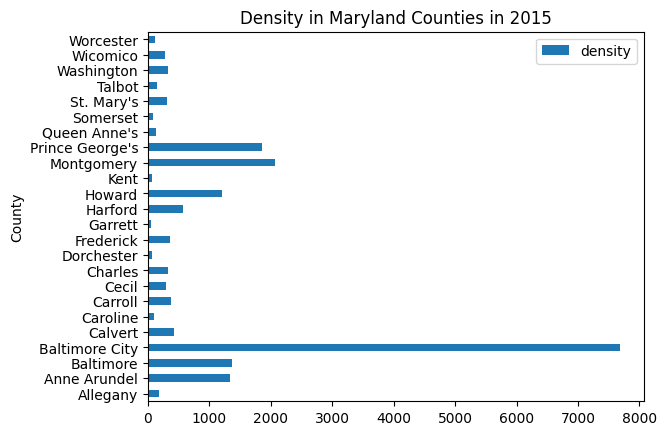

In [14]:
#Plot horizontal bar charts of density for each county from 2010-2015

#2010 density by county
plot_2010_housing = only_2010.plot.barh(x="county",y="density")
plot_2010_housing.set_title('Density in Maryland Counties in 2010')
plot_2010_housing.set_ylabel('County')

#2011 density by county
plot_2011_housing = only_2011.plot.barh(x="county",y="density")
plot_2011_housing.set_title('Density in Maryland Counties in 2011')
plot_2011_housing.set_ylabel('County')

#2012 density by county
plot_2012_housing = only_2012.plot.barh(x="county",y="density")
plot_2012_housing.set_title('Density in Maryland Counties in 2012')
plot_2012_housing.set_ylabel('County')

#2013 density by county
plot_2013_housing = only_2013.plot.barh(x="county",y="density")
plot_2013_housing.set_title('Density in Maryland Counties in 2013')
plot_2013_housing.set_ylabel('County')

#2014 density by county
plot_2014_housing = only_2014.plot.barh(x="county",y="density")
plot_2014_housing.set_title('Density in Maryland Counties in 2014')
plot_2014_housing.set_ylabel('County')

#2015 density by county
plot_2015_housing = only_2015.plot.barh(x="county",y="density")
plot_2015_housing.set_title('Density in Maryland Counties in 2015')
plot_2015_housing.set_ylabel('County')

Text(0.5, 0, 'Year')

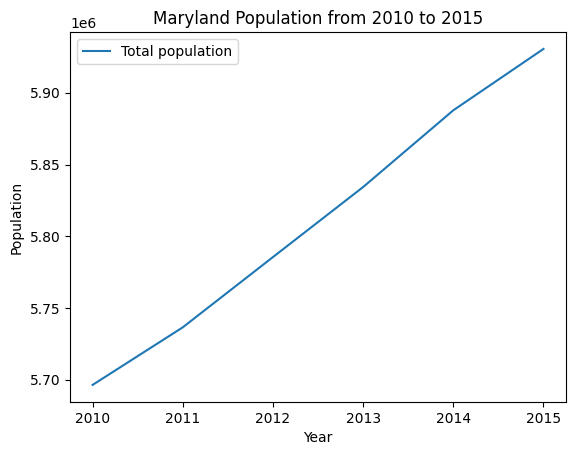

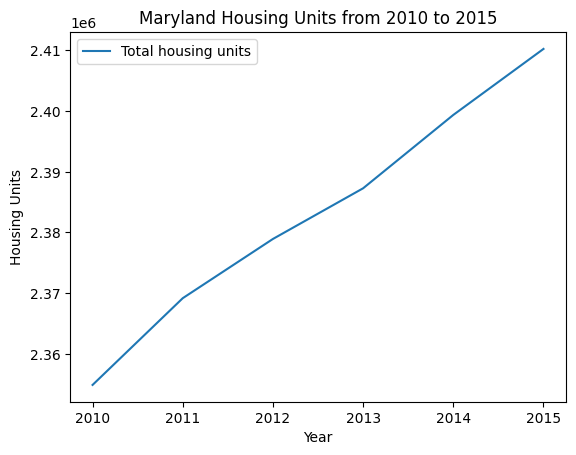

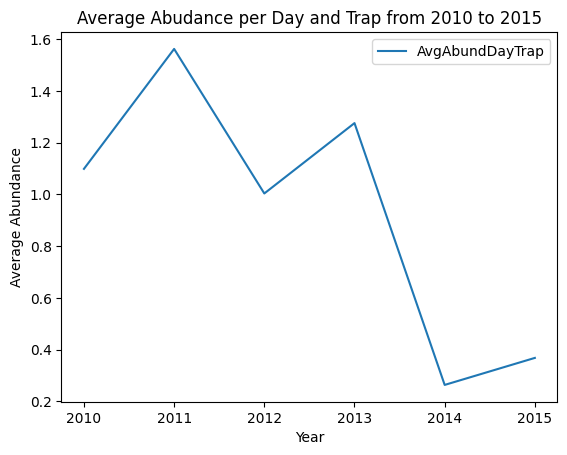

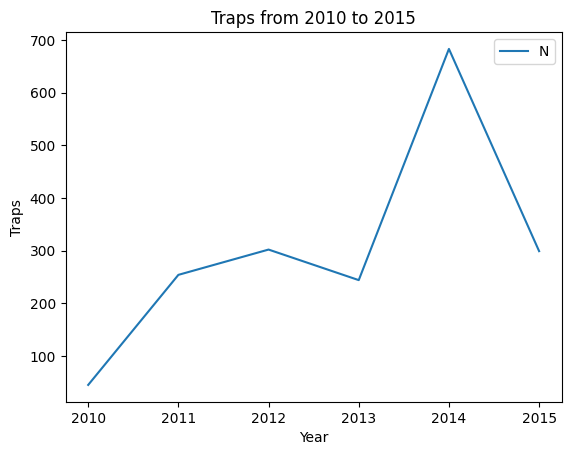

In [15]:
#Plot line charts of state information from 2010-2015

df_outer = pd.merge(bee_df, pop_df, how = 'outer', left_on =['Year','County'], right_on=['year','county'])
yearly_sum = df_outer[['year','Total population','Total housing units','N']].groupby(['year']).sum().reset_index()
yearly_mean = df_outer[['year','AvgAbundDayTrap']].groupby(['year']).mean().reset_index()

#State population from 2010 to 2015
yearly_population = yearly_sum.plot('year','Total population')
yearly_population.set_title('Maryland Population from 2010 to 2015')
yearly_population.set_ylabel('Population')
yearly_population.set_xlabel('Year')

#State housing units from 2010 to 2015
yearly_housing = yearly_sum.plot('year','Total housing units')
yearly_housing.set_title('Maryland Housing Units from 2010 to 2015')
yearly_housing.set_ylabel('Housing Units')
yearly_housing.set_xlabel('Year')

#State average abundance by day and trap from 2010 to 2015
yearly_abundance = yearly_mean.plot('year','AvgAbundDayTrap')
yearly_abundance.set_title('Average Abudance per Day and Trap from 2010 to 2015')
yearly_abundance.set_ylabel('Average Abundance')
yearly_abundance.set_xlabel('Year')

#State traps from 2010 to 2015
yearly_traps = yearly_sum.plot('year','N')
yearly_traps.set_title('Traps from 2010 to 2015')
yearly_traps.set_ylabel('Traps')
yearly_traps.set_xlabel('Year')

Data visualizations to address limitations

(-8873188.441065, -8329736.526235, 4551335.382930003, 4838819.970870003)

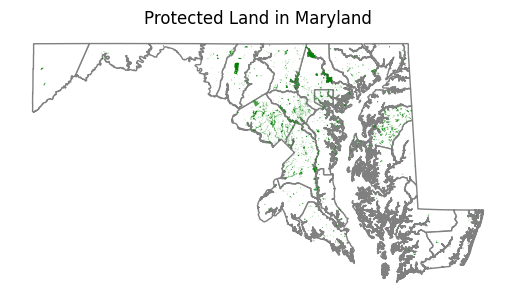

In [147]:
#Visualization of protected land across Maryland

# Read County Boundaries shape file
boundaries = gpd.read_file('BNDY_CountyPhyBoundaryDetailed_SHA.shp')

#Plot
base = boundaries.plot(color='white', edgecolor='gray')
protectedland = gpd.read_file('ENVL_LocalProtectedLands_DNR.shp')
base = boundaries.plot(color='white', edgecolor='gray')
md = protectedland.plot(ax=base, marker='o', color='green', markersize=5)
md.set_title("Protected Land in Maryland")
md.axis('off')